In [105]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, variation
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from sequencing_tools.viz_tools import color_encoder
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

def model_var(phi, mu):
    return mu * (1 + phi * mu)
    
def model_cv(phi, mu):
    var = model_var(phi, mu)
    cv = np.sqrt(var) / mu
    return cv

def fit_dispersion(phi, mu, var):
    pred_var = model_var(phi, mu)
    return mean_squared_error(var, pred_var)


For RNA-seq, [variance](https://academic.oup.com/nar/article/45/11/e104/3091649) can be modeled by:

$$ \sigma^2 = \mu (1+\phi \mu)  $$

In [111]:
df = pd.read_table('../data/normalized_counts.tsv') \
    .pipe(lambda d: d[~d.Type.str.contains('rRNA')])\
    .drop(['Name','Type'], axis=1)\
    .rename(columns = lambda x: x.replace('.','-'))\
    .rename(columns = {'ID':'seq_id'}) \
    .filter(regex='-A-|NTT|NTC|seq_id')
df.head()

,NTCF1,NTCF2,NTCF3,NTTF1,NTTF2,NTTF3,ABRF-ILMN-L-A-1,ABRF-ILMN-L-A-2,ABRF-ILMN-L-A-3,ABRF-ILMN-R-A-1,ABRF-ILMN-R-A-2,ABRF-ILMN-R-A-3,ABRF-ILMN-RIBO-A-1,ABRF-ILMN-RIBO-A-2,ABRF-ILMN-RIBO-A-3,ABRF-ILMN-RIBO-A-4,ABRF-ILMN-V-A-1,ABRF-ILMN-V-A-2,ABRF-ILMN-V-A-3,seq_id
0,22.062930,31.445990,29.123368,66.625640,33.779264,36.591035,8.822113,9.862625,7.045380,6.892471,7.981477,8.154884,1.490879,0.000000,0.000000,1.969137,7.094552,7.364849,3.206485,ENSG00000199197
1,10.382555,15.722995,16.461034,22.208547,20.106705,23.418262,1.411538,3.381472,2.241712,2.297490,0.498842,4.349272,7.454396,0.000000,5.179446,3.938274,2.728674,1.841212,3.206485,ENSG00000199218
2,154.440510,167.235491,88.636338,190.732224,135.117057,99.527615,4.587499,4.508629,1.601223,5.169353,3.990738,2.174636,0.000000,4.251041,0.000000,0.000000,6.003082,4.603030,3.206485,ENSG00000199319
3,37.636763,25.728537,49.383103,62.706485,45.039019,32.200111,5.293268,3.099682,3.522690,0.574373,1.995369,1.630977,2.981758,0.000000,0.000000,0.000000,3.274408,1.841212,3.847783,ENSG00000199420
4,11.680375,8.576179,3.798700,18.289391,19.302437,16.100055,0.352885,1.127157,1.601223,1.723118,1.496527,1.630977,0.000000,0.000000,0.000000,0.000000,0.000000,2.301515,1.923891,ENSG00000199475


In [113]:
mv_df = df \
    .pipe(pd.melt, id_vars = ['seq_id'], var_name = 'samplename', value_name = 'norm_count')\
    .assign(prep = lambda d: d.samplename.str.replace('[0-9]+$',''))\
    .groupby(['seq_id','prep'], as_index=False) \
    .agg({'norm_count':['mean','std','var',variation]}) 
new_col = mv_df.columns.get_level_values(0) + mv_df.columns.get_level_values(1)
mv_df.columns = new_col
mv_df.head()

KeyboardInterrupt: 

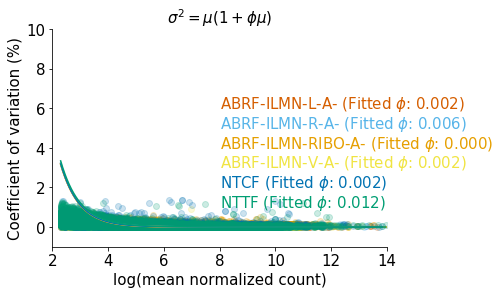

In [115]:
ax = plt.subplot(111)
prep_ce = color_encoder()
prep_ce.fit(mv_df.prep.unique())
for i, (prep, prep_d) in enumerate(mv_df.groupby('prep')):
    
    sub_d = prep_d[prep_d['norm_countmean'] > 10]
    gene_mu = sub_d['norm_countmean']
    gene_cv =  sub_d['norm_countvariation']
    gene_var = sub_d['norm_countvar']
    
    fitted = minimize(fit_dispersion, [2], args = (gene_mu, gene_var))
    phi = fitted.x[0]
    
    modeled_mean = np.arange(gene_mu.min(), 100, 0.1)
    modeled_mean = np.append(modeled_mean, np.arange(100, gene_mu.max()))
    modeled_var = model_var(phi, modeled_mean)
    modeled_std = np.sqrt(modeled_var) / modeled_mean
    modeled_cv = modeled_std/modeled_mean
    
    color = prep_ce.encoder[prep]
    disp = prep + ' (Fitted $\phi$: %.3f)' %phi
    ax.plot(np.log(modeled_mean), modeled_cv*100, color = color)
    ax.scatter(np.log(gene_mu), gene_cv, alpha=0.2, color = color)
    ax.text(8,6 - i, disp, fontsize=15, color = color)
ax.set_xlim(2, 14)
ax.set_ylim(-1,10)  
ax.set_xlabel('log(mean normalized count)')
ax.set_ylabel('Coefficient of variation (%)')
ax.set_title(r'$\sigma^2 = \mu (1+\phi \mu)$', size=15)
sns.despine()

In [116]:
def plot_mean_var(mv_df, ax, log_scale=False):
    prep_ce = color_encoder()
    prep_ce.fit(mv_df.prep.unique())
    
    for i, (prep, prep_d) in enumerate(mv_df.groupby('prep')):
    
        gene_mu = prep_d['norm_countmean']
        gene_cv =  prep_d['norm_countvariation']
        gene_var = prep_d['norm_countvar']
    
        fitted = minimize(fit_dispersion, [2], args = (gene_mu, gene_var))
        phi = fitted.x[0]
    
        modeled_mean = np.arange(gene_mu.min(), 100, 0.1)
        modeled_mean = np.append(modeled_mean, np.arange(100, gene_mu.max()))
        modeled_var = model_var(phi, modeled_mean)
        modeled_std = np.sqrt(modeled_var) / modeled_mean
        modeled_cv = modeled_std/modeled_mean
    
    
        color = prep_ce.encoder[prep]
        disp = prep + ' ($\phi$: %.3f)' %phi
    
        if log_scale:
            ax.plot(np.log(modeled_mean), np.log(modeled_var), color = color)
            ax.scatter(np.log(gene_mu), np.log(gene_var), alpha=0.1, color = color)
            ax.text(1, 18 - i*2, disp, fontsize=15, color = color)
    
        else:
            ax.plot(modeled_mean, modeled_var, color = color)
            ax.scatter(gene_mu, gene_var, color = color, alpha=0.8)
            ax.text(1e5, 1e9 - i*1e8, disp, fontsize=15, color = color)

    if log_scale:
        ax.set_xlim(0,13)
        ax.set_ylim(0,22)
        ax.set_xlabel('log($\mu$)')
        ax.set_ylabel('log($\sigma^2$)')
        
    else:
        xt = np.arange(0,mv_df.norm_countmean.max(), 5e4)
        ax.set_xlim(0, mv_df.norm_countmean.max())
        ax.set_xticks(xt)
        ax.set_xticklabels(xt, rotation = 70,
                          rotation_mode = 'anchor', ha = 'right')
        ax.set_xlabel('$\mu$')
        ax.set_ylabel('$\sigma^2$')

    ax.plot([0,1e9], [0,1e9], color='red')
    sns.despine()

    ax.set_title(r'$\sigma^2 = \mu (1+\phi \mu)$', size=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-pac

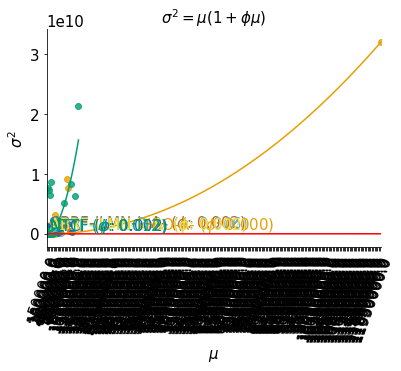

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_mean_var(mv_df, ax, log_scale = False)
fig.savefig('../figures/mean_var_plot.eps')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel

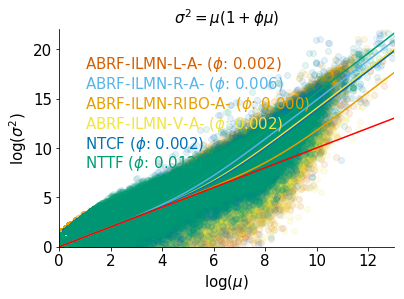

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_mean_var(mv_df, ax, log_scale = True)
fig.savefig('../figures/mean_var_plot_log.eps', bbox_inches = 'tight')
fig.savefig('../figures/mean_var_plot_log.png', bbox_inches = 'tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


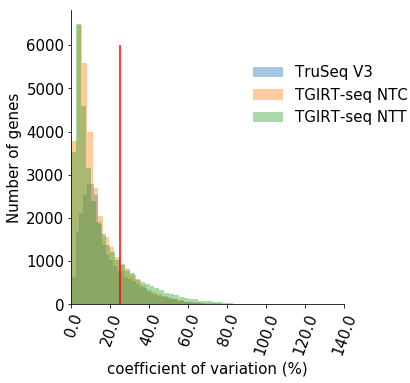

In [131]:
cutoff = 10
def prep_conversion(x):
    prep = ''
    if 'RIBO' in x:
        prep = 'TruSeq V3'
    else:
        prep = 'TGIRT-seq ' + x
    return prep

poisson_mu = mv_df\
    .query('norm_countmean > %i' %cutoff)\
    .query('prep == "NTTF"').norm_countmean
poisson_cv = 1/np.sqrt(poisson_mu)
p = sns.FacetGrid(data = mv_df\
                      .query('norm_countmean > %i' %cutoff)\
                      .pipe(lambda d: d[~d.prep.str.contains('-[RLV]-A')])\
                      .assign(cv = lambda d: 100 * d.norm_countvariation)\
                      .assign(prep = lambda d: d.prep.str.replace('F$',''))\
                      .assign(prep = lambda d: d.prep.map(prep_conversion)), 
                  hue = 'prep', size=5)
p.map(sns.distplot, 'cv', kde=False, bins=50)
p.add_legend(title = '', bbox_to_anchor=(0.8,0.8), fontsize=15)
p.set_axis_labels('coefficient of variation (%)', 
                  'Number of genes' )
ax = p.fig.axes[0]
ax.set_xlim(0,140)
#ax.set_ylim(0,0.1)
ax.vlines(x = 25, ymin=0,ymax = 6000, color='red')
xts = np.linspace(0,140, 8)
xt = ax.set_xticks(xts)
xt = ax.set_xticklabels(xts, rotation = 70, rotation_mode = 'anchor', ha = 'right')
p.savefig('../figures/cv_plot.eps')
p.savefig('../figures/cv_plot.png')

In [134]:
mv_df\
    .query('norm_countmean > %i' %cutoff)\
    .assign(reprod = lambda d: np.where(d.norm_countvariation <= 0.25,'<25%','>25%')) \
    .assign(gene_count = 1)\
    .groupby(['prep','reprod'], as_index=False)\
    .agg({'gene_count':'sum'}) \
    .assign(reprod_rate = lambda d: d.groupby(['prep']).gene_count.transform(lambda x: x/x.sum())) \
    .query('reprod == "<25%"')

,prep,reprod,gene_count,reprod_rate
0,ABRF-ILMN-L-A-,<25%,33257,0.996883
2,ABRF-ILMN-R-A-,<25%,32703,0.972811
4,ABRF-ILMN-RIBO-A-,<25%,22006,0.790076
6,ABRF-ILMN-V-A-,<25%,33650,0.985099
8,NTCF,<25%,28697,0.851189
10,NTTF,<25%,27275,0.796792


In [135]:
mv_df\
    .query('norm_countmean > %i' %cutoff)\
    .assign(reprod = lambda d: np.where(d.norm_countvariation <= 0.25,'<25%','>25%')) \
    .assign(gene_count = 1)\
    .groupby(['prep'], as_index=False)\
    .agg({'gene_count':'sum'}) \

,prep,gene_count
0,ABRF-ILMN-L-A-,33361
1,ABRF-ILMN-R-A-,33617
2,ABRF-ILMN-RIBO-A-,27853
3,ABRF-ILMN-V-A-,34159
4,NTCF,33714
5,NTTF,34231
